In [8]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

%matplotlib inline

In [9]:
base_directory = '~/workspace/personal/datasets/cancer'

columns = ['Sample code number', 'Clump Thickness',
'Uniformity of Cell Size',
'Uniformity of Cell Shape',
'Marginal Adhesion',
'Single Epithelial Cell Size',
'Bare Nuclei',
'Bland Chromatin',
'Normal Nucleoli',
'Mitoses',
'Class']

In [10]:
def using_model(model, scoring, cv):
    print("****************** {} ******************".format(model))
    if scoring is not None:
        scores_ = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv)
        print("scoring={} cv={}".format(scoring, cv), scores_.mean(), scores_.std())
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print("accuracy_score=", accuracy_score(y_test, y_predict))
    print("precision_score=", precision_score(y_test, y_predict, average='micro'))
    print("recall_score=", recall_score(y_test, y_predict, average='micro'))
    

In [11]:
def load_csv_data(directory, file_name, names=None, header=None, skiprows=0, skipinitialspace=True):
    return pd.read_csv(os.path.join(directory, file_name), names=names, header=header, skiprows=skiprows, skipinitialspace=skipinitialspace)

In [12]:
def confusion_matrix(model, X_train, Y_train):
    from sklearn.metrics import confusion_matrix

    y_scores_ = cross_val_predict(model, X_train, Y_train, cv=3, method="decision_function")
    model.fit(X_train, Y_train)
    Y_predict = model.predict(X_train)
    conf_mx = confusion_matrix(Y_train, Y_predict)
    plt.matshow(conf_mx, cmap=plt.cm.gray)
#     print("accuracy_score=", accuracy_score(Y_train, Y_predict))
#     print("precision_score=", precision_score(Y_train, Y_predict))
#     print("recall_score=", recall_score(Y_train, Y_predict))
    print(lb.classes_)
    print(lb.transform(lb.classes_))
    print(conf_mx)
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums

    np.fill_diagonal(norm_conf_mx, 0)
    plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

In [13]:
df = load_csv_data(base_directory, 'breast-cancer-wisconsin.data', names=columns)
df = df.drop('Sample code number', axis=1)

In [14]:
df.describe()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [15]:
df.loc[df['Bare Nuclei'] == '?', 'Bare Nuclei'] = np.nan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Clump Thickness              699 non-null    int64 
 1   Uniformity of Cell Size      699 non-null    int64 
 2   Uniformity of Cell Shape     699 non-null    int64 
 3   Marginal Adhesion            699 non-null    int64 
 4   Single Epithelial Cell Size  699 non-null    int64 
 5   Bare Nuclei                  683 non-null    object
 6   Bland Chromatin              699 non-null    int64 
 7   Normal Nucleoli              699 non-null    int64 
 8   Mitoses                      699 non-null    int64 
 9   Class                        699 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 54.7+ KB


array([[<AxesSubplot: xlabel='Clump Thickness', ylabel='Clump Thickness'>,
        <AxesSubplot: xlabel='Uniformity of Cell Size', ylabel='Clump Thickness'>,
        <AxesSubplot: xlabel='Uniformity of Cell Shape', ylabel='Clump Thickness'>,
        <AxesSubplot: xlabel='Marginal Adhesion', ylabel='Clump Thickness'>,
        <AxesSubplot: xlabel='Single Epithelial Cell Size', ylabel='Clump Thickness'>,
        <AxesSubplot: xlabel='Bland Chromatin', ylabel='Clump Thickness'>,
        <AxesSubplot: xlabel='Normal Nucleoli', ylabel='Clump Thickness'>,
        <AxesSubplot: xlabel='Mitoses', ylabel='Clump Thickness'>],
       [<AxesSubplot: xlabel='Clump Thickness', ylabel='Uniformity of Cell Size'>,
        <AxesSubplot: xlabel='Uniformity of Cell Size', ylabel='Uniformity of Cell Size'>,
        <AxesSubplot: xlabel='Uniformity of Cell Shape', ylabel='Uniformity of Cell Size'>,
        <AxesSubplot: xlabel='Marginal Adhesion', ylabel='Uniformity of Cell Size'>,
        <AxesSubplot: xla

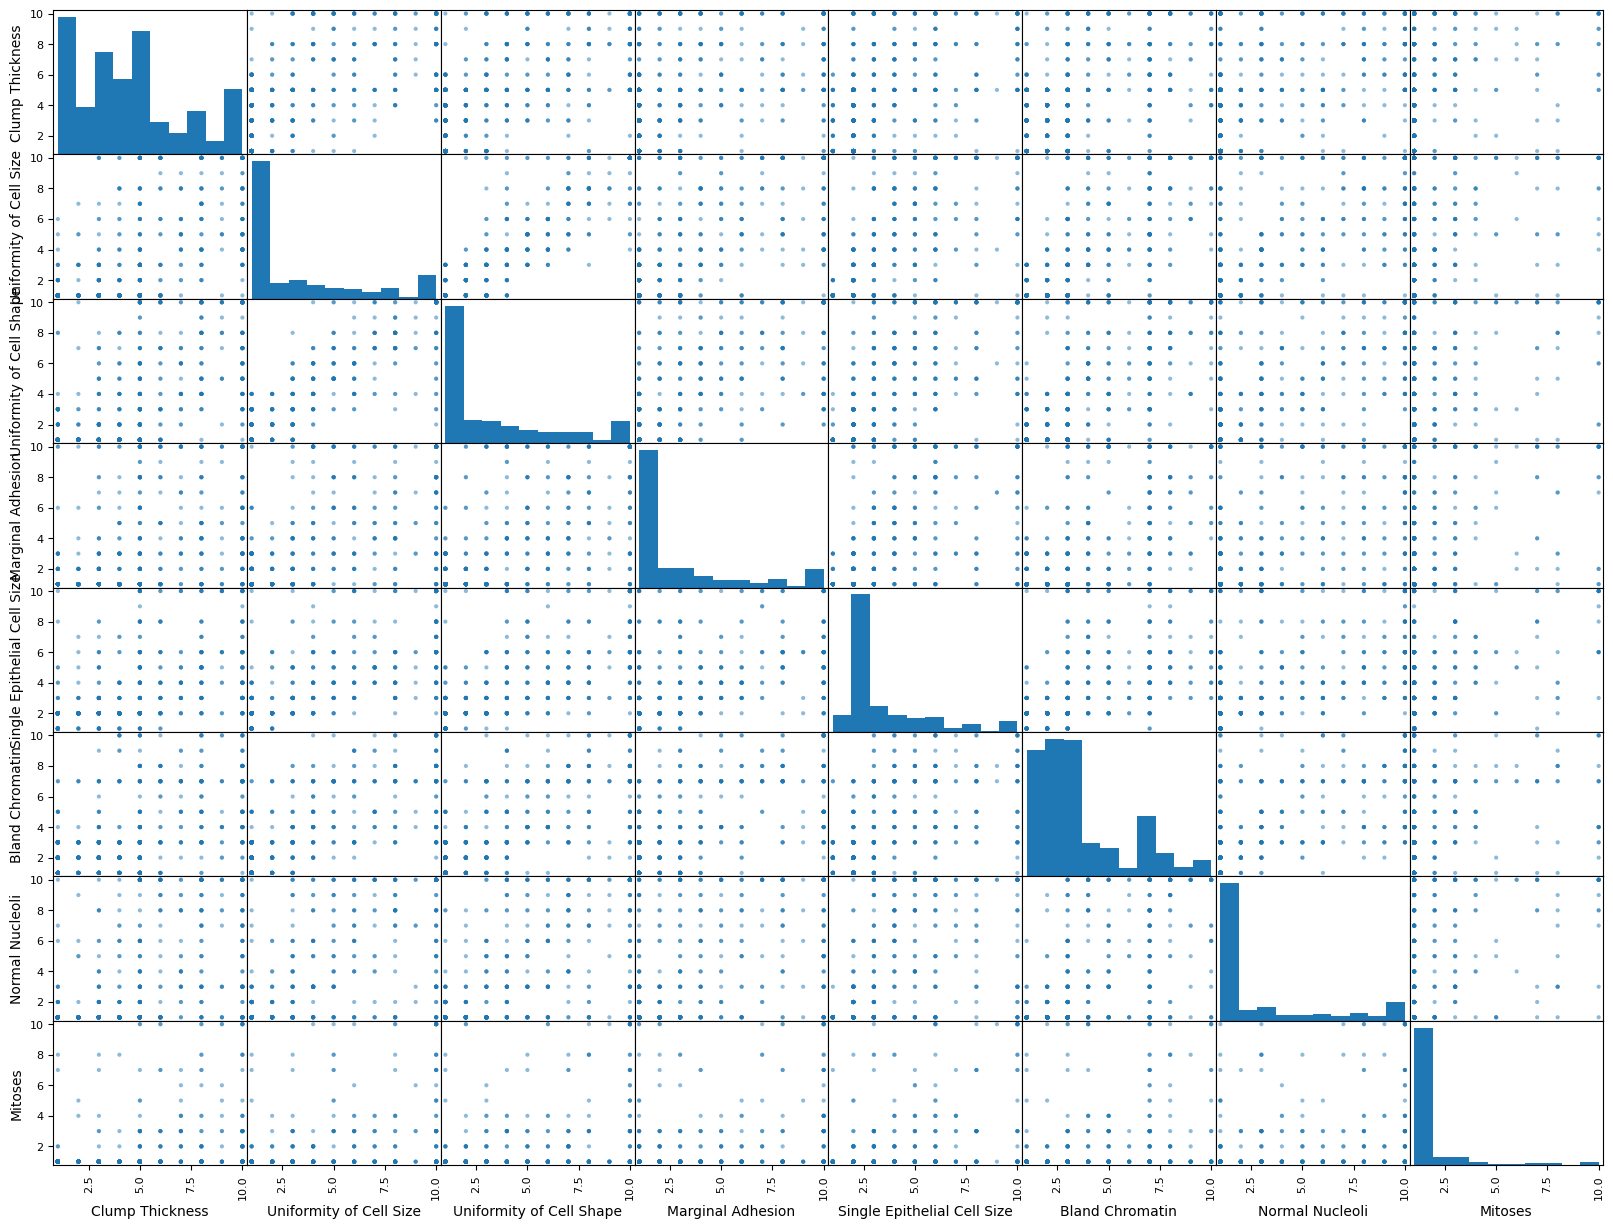

In [16]:
pd.plotting.scatter_matrix(df.drop('Class', axis=1), figsize=(20, 15))

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

for train_index, test_index in split.split(
    df.drop('Class', axis=1),
    df['Class']):
        train_set = df.loc[train_index]
        test_set = df.loc[test_index]

In [18]:
X_train = train_set.drop('Class', axis=1)
y_train = train_set['Class']

X_test = test_set.drop('Class', axis=1)
y_test = test_set['Class']


In [19]:
num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy="median")),
            ('std_scaler', StandardScaler()),
            #('minmax_scaler', MinMaxScaler()),
        ])

X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.fit_transform(X_test)

lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [20]:
using_model(LogisticRegression(max_iter=700, multi_class="multinomial", solver='lbfgs', C=10), None, cv=10)

****************** LogisticRegression(C=10, max_iter=700, multi_class='multinomial') ******************
accuracy_score= 0.9571428571428572
precision_score= 0.9571428571428572
recall_score= 0.9571428571428572


In [21]:
using_model(SGDClassifier(), None, 10)

****************** SGDClassifier() ******************
accuracy_score= 0.9642857142857143
precision_score= 0.9642857142857143
recall_score= 0.9642857142857143


In [22]:
svc = SVC()
using_model(svc, None, 10)
svc._gamma, svc.C

****************** SVC() ******************
accuracy_score= 0.9571428571428572
precision_score= 0.9571428571428572
recall_score= 0.9571428571428572


(0.1111111111111111, 1.0)

In [23]:
using_model(RandomForestClassifier(), None, 10)

****************** RandomForestClassifier() ******************
accuracy_score= 0.95
precision_score= 0.95
recall_score= 0.95


In [24]:
## Soft Voting using Bagging

using_model(BaggingClassifier(estimator=SGDClassifier(), n_estimators=10, random_state=0), None, 10)

****************** BaggingClassifier(estimator=SGDClassifier(), random_state=0) ******************
accuracy_score= 0.9642857142857143
precision_score= 0.9642857142857143
recall_score= 0.9642857142857143


In [25]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
dsc_clf = DecisionTreeClassifier()

voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf), ('dt', dsc_clf)],
        voting='hard')

using_model(voting_clf, None, 10)

****************** VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC()),
                             ('dt', DecisionTreeClassifier())]) ******************
accuracy_score= 0.95
precision_score= 0.95
recall_score= 0.95


In [26]:
using_model(DecisionTreeClassifier(), None, 10)

****************** DecisionTreeClassifier() ******************
accuracy_score= 0.9071428571428571
precision_score= 0.9071428571428571
recall_score= 0.9071428571428571


In [27]:
a = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15), n_estimators=225, 
                       algorithm="SAMME.R", learning_rate=0.3)
using_model(a, None, 10)

****************** AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=15),
                   learning_rate=0.3, n_estimators=225) ******************
accuracy_score= 0.9214285714285714
precision_score= 0.9214285714285714
recall_score= 0.9214285714285714


In [28]:
a1 = AdaBoostClassifier(LogisticRegression(max_iter=500, multi_class="multinomial"),
                        n_estimators=225, algorithm="SAMME.R", learning_rate=0.3)
using_model(a1, None, 10)

****************** AdaBoostClassifier(estimator=LogisticRegression(max_iter=500,
                                                multi_class='multinomial'),
                   learning_rate=0.3, n_estimators=225) ******************
accuracy_score= 0.9571428571428572
precision_score= 0.9571428571428572
recall_score= 0.9571428571428572


In [29]:
import xgboost

xgb_clf = xgboost.XGBClassifier()
using_model(xgb_clf, None, 10)


****************** XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) ******************
accuracy_score= 0.9571428571428572
precision_score= 0.9571428571428572
recall_score= 0.9571428571428572


In [30]:
from sklearn.ensemble import GradientBoostingClassifier
using_model(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0), None, 10)

****************** GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0) ******************
accuracy_score= 0.9571428571428572
precision_score= 0.9571428571428572
recall_score= 0.9571428571428572


In [31]:
from sklearn.ensemble import HistGradientBoostingClassifier

using_model(HistGradientBoostingClassifier(), None, 10)

****************** HistGradientBoostingClassifier() ******************
accuracy_score= 0.9571428571428572
precision_score= 0.9571428571428572
recall_score= 0.9571428571428572


In [32]:
ovr = OneVsRestClassifier(SVC())

using_model(ovr, None, 10)

****************** OneVsRestClassifier(estimator=SVC()) ******************
accuracy_score= 0.9571428571428572
precision_score= 0.9571428571428572
recall_score= 0.9571428571428572


In [33]:
param_grid = [
        {'n_estimators': [50, 60, 70, 71, 75, 100, 120, 150], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]


# m = RandomForestRegressor()
# m.fit(X_train, y_train)
    
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'max_features': 2, 'n_estimators': 70}
RandomForestClassifier(max_features=2, n_estimators=70)


In [34]:
using_model(RandomForestClassifier(max_features=2, n_estimators=120), None, 10)

****************** RandomForestClassifier(max_features=2, n_estimators=120) ******************
accuracy_score= 0.9571428571428572
precision_score= 0.9571428571428572
recall_score= 0.9571428571428572


In [35]:
param_grid = [
        {'max_iter': [500, 600, 1000, 1200, 1300, 1310, 1350, 1400],
         'penalty': ['l2', 'l1', 'elasticnet', None]}
    ]

grid_search = GridSearchCV(SGDClassifier(), param_grid, cv=10)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

using_model(SGDClassifier(max_iter=1300, penalty='elasticnet'), None, 10)

{'max_iter': 500, 'penalty': 'elasticnet'}
SGDClassifier(max_iter=500, penalty='elasticnet')
****************** SGDClassifier(max_iter=1300, penalty='elasticnet') ******************
accuracy_score= 0.9642857142857143
precision_score= 0.9642857142857143
recall_score= 0.9642857142857143


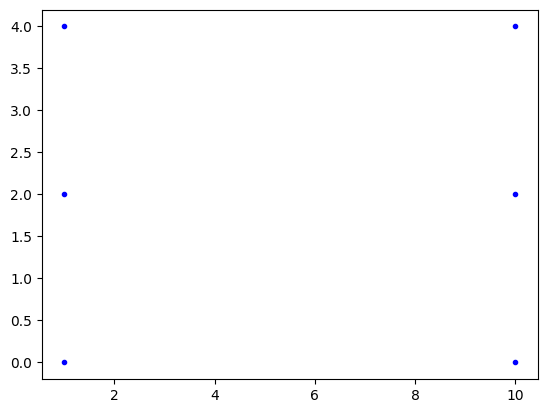

In [36]:
X = np.array([[1, 2],
              [1, 4], 
              [1, 0],
              [10, 2], 
              [10, 4], 
              [10, 0]])
plt.plot(X[0:,0], X[0:, 1], 'b.')

In [37]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)



In [38]:
kmeans.labels_

array([1, 1, 1, 0, 0, 0], dtype=int32)

In [39]:
kmeans.predict([[0, 0], [12, 3]])

array([1, 0], dtype=int32)

In [40]:
X_train.shape, y_train.shape

((559, 9), (559,))

In [41]:
import tensorflow as tf
from tensorflow import keras

nn = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[9]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(5, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2023-02-11 12:23:43.583680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 12:23:52.869406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
nn.fit(X_train, y_train, epochs=30)

Epoch 1/30
18/18 [==============================] - 1s 1ms/step - loss: 0.5146 - accuracy: 0.7692
Epoch 2/30
18/18 [==============================] - 0s 1ms/step - loss: 0.3285 - accuracy: 0.9338
Epoch 3/30
18/18 [==============================] - 0s 1ms/step - loss: 0.2139 - accuracy: 0.9714
Epoch 4/30
18/18 [==============================] - 0s 1ms/step - loss: 0.1521 - accuracy: 0.9714
Epoch 5/30
18/18 [==============================] - 0s 1ms/step - loss: 0.1204 - accuracy: 0.9714
Epoch 6/30
18/18 [==============================] - 0s 1ms/step - loss: 0.1030 - accuracy: 0.9714
Epoch 7/30
18/18 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.9750
Epoch 8/30
18/18 [==============================] - 0s 1ms/step - loss: 0.0865 - accuracy: 0.9750
Epoch 9/30
18/18 [==============================] - 0s 2ms/step - loss: 0.0823 - accuracy: 0.9732
Epoch 10/30
18/18 [==============================] - 0s 1ms/step - loss: 0.0792 - accuracy: 0.9732
Epoch 11/30
18/18 [

In [43]:
nn.evaluate(X_test, y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.1012 - accuracy: 0.9714


[0.101224884390831, 0.9714285731315613]

In [44]:
r = nn.predict(X_test) 

5/5 [==============================] - 0s 1ms/step


In [45]:
r[1]

array([0.00017295], dtype=float32)